In [ ]:
!pip install -U gymnasium pygame moviepy
!pip install gymnasium[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.1
    Uninstalling pygame-2.5.1:
      Successfully uninstalled pygame-2.5.1


# Previous Code

In [9]:
import gymnasium as gym
from gymnasium import RewardWrapper, wrappers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import FeatureUnion
from typing import List, Union
from pathlib import Path
import os
# from google.colab import files

In [ ]:
class StandardScaler():

    def __init__(self):
        self.mean = None
        self.standard_deviation = None

    def fit(self, data):
        self.mean = np.mean(data, axis=0)
        self.standard_deviation = np.sqrt(np.mean(np.square(data-self.mean), axis=0))

    def transform(self, data):
        return (data-self.mean)/self.standard_deviation

In [ ]:
class RadialBasisFunction(object):
    """
    Radial Basis Function.
    """
    def __init__(self, RBF_kernels):
        """
        Parameters:
        -RBF_kernels: List of RBF kernel objects.
        """
        self.RBF_kernels = RBF_kernels

    def transform(self, state):
        """
        Transform a state into a feature vector using each kernel.

        Parameters:
        -state: State to transform.

        Returns:
        -feature vector.
        """
        vector = np.array([kernel.transform(state) for kernel in self.RBF_kernels]).flatten().reshape(1, -1)
        # append a column of one's to the back for a bias term
        return np.hstack((vector, np.ones((vector.shape[0], 1))))









In [ ]:
class RBF_kernel(object):
    """
    RBF Kernel.
    """

    def __init__(self, X, num_C, sigma):
        """
        Parameters:
        -X: Input data.
        -num_C: Number of centers of the RBFs.
        -sigma: Sigma of the Gaussian.
        """
        self.sigma=sigma
        rng = np.random.default_rng()
        self.centers = rng.choice(X, num_C)


    def transform(self, state):
        """
        Transform a state into a feature vector.

        Parameters:
        -state: State to transform.

        Returns:
        -feature vector.
        """
        return np.exp(-np.sum(np.square(state - self.centers) / (2 * self.sigma ** 2), axis=1))



In [ ]:
# code the output layer class
class DenseLayer(object):
    """
    Dense Layer class.
    """
    def __init__(self, input_size, output_size):
        """
        Parameters:
        -input_size: Input size.
        -output_size: Output size.
        """
        self.input_size = input_size
        self.output_size = output_size
        # add one to input size to account for bias term
        self.W = np.random.randn(input_size+1, output_size)


    def forward(self, X):
        """
        Forward pass.

        Parameters:
        -X: Input data.

        Returns:
        -output: Output of the layer.
        """
        self.X = X
        return np.dot(X, self.W)

    def backward(self, output_gradient, learning_rate, action):
        """
        Backward pass.

        Parameters:
        -output_gradient: Gradient of the output.
        -learning_rate: Learning rate.

        Returns:
        -input_gradient: Gradient of the input.
        """
        self.W[:, action] += learning_rate * np.dot(output_gradient, self.X)
        return np.dot(output_gradient, self.W)



In [ ]:
# code a temporal difference loss function since that is what reinforcement learning uses
class TemporalDifferenceLoss(object):
    """
    Temporal Difference Loss class.
    """

    def forward(self, y_true, y_pred):
        """
        Forward pass.

        Parameters:
        -y_true: True labels.
        -y_pred: Predicted labels.

        Returns:
        -loss: Temporal difference loss.
        """
        return y_true - y_pred

    def backward(self, y_true, y_pred):
        """
        Backward pass.

        Parameters:
        -y_true: True labels.
        -y_pred: Predicted labels.

        Returns:
        -input_gradient: Gradient of the input.
        """
        return -1


In [ ]:
# code a model class
class Model(object):
    """
    Model class.
    """
    def __init__(self, layers, loss, transformer=None, scaler=None):
        """
        Parameters:
        -layers: List of layers.
        -loss: Loss class.
        -transformer: Transformer class. Defaults to None.
        """
        self.layers = layers
        self.loss = loss
        self.transformer = transformer
        self.scaler = scaler


    def forward(self, X):
        """
        Forward pass.

        Parameters:
        -X: Input data.

        Returns:
        -output: Output of the model.
        """
        if self.scaler:
            X = self.scaler.transform(X)
        if self.transformer:
            X = self.transformer.transform(X)
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, output_gradient, learning_rate, action):
        """
        Backward pass.

        Parameters:
        -output_gradient: Gradient of the output.
        -learning_rate: Learning rate.

        Returns:
        -input_gradient: Gradient of the input.
        """
        for layer in reversed(self.layers):
            output_gradient = layer.backward(output_gradient, learning_rate, action)
        return output_gradient


    def fit(self, X, y, epochs, learning_rate):
        """
        Fit.

        Parameters:
        -X: Input data.
        -y: True labels.
        -epochs: Number of epochs.
        -learning_rate: Learning rate.

        Returns:
        -losses: List of losses.
        """
        losses = []

        for epoch in range(epochs):
            output = self.forward(X)
            loss = self.loss.forward(y, output)
            losses.append(loss)
            if epoch % 100 == 0:
                print('Epoch: {0}, Loss: {1}'.format(epoch, loss))
            gradient = self.loss.backward(y, output)
            for layer in reversed(self.layers):
                gradient = layer.backward(gradient, learning_rate)

        return losses





In [ ]:
# code a new agent class that can use a continuous observation space and uses
# neural networks to learn
class Agent:
    def __init__(self, env, learning_model, learning_rate, gamma, epsilon):
        """
        Parameters:
        -env: Environment.
        -learning_model: Learning model.
        -gamma: Discount factor.
        -epsilon: Epsilon greedy random action threshold.
        """
        self.env = env
        self.learning_model = learning_model
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon

    def get_action(self, state):
        """
        Get action from the Q-table.

        Parameters:
        -state: int of length n_features representing the assigned bin of each feature

        Returns:
        -action: random or optimal action
        """
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.learning_model.forward(state))

    def run_episode(self):
        """
        Run an episode of the agent.

        Returns:
        -tot_reward: Total reward for the episode.
        """
        state, _ = self.env.reset()
        done = False
        tot_reward = 0
        while not done:
            action = self.get_action(state)
            next_state, reward, term, trunc, _ = self.env.step(action)
            tot_reward += reward
            target = reward + self.gamma * np.max(self.learning_model.forward(next_state))
            prediction = self.learning_model.forward(state)[:, action]
            loss = self.learning_model.loss.forward(target, prediction)
            output_gradient = self.learning_model.loss.backward(target, prediction)
            output_gradient = self.learning_model.backward(output_gradient, self.learning_rate, action)
            state = next_state
            if term or trunc:
                done = True
        return tot_reward, loss


    def train(self, episodes):
        """
        Train the agent for a number of episodes.

        Parameters:
        -episodes: Number of episodes to train for.

        Returns:
        -rewards: List of rewards per episode.
        """

        rewards = []
        losses = []
        for i in range(episodes):
            reward, loss = self.run_episode()
            rewards.append(reward)
            losses.append(loss)
            if i % 10 == 0:
                print(f"Episode {i}; episode reward: {rewards[-1]}; AVG/100 reward: {np.mean(rewards[-100:])}; loss: {losses[-1]}")

        return rewards, losses

In [ ]:
# instantiate environment and generate an array of sample states to fit standard scaler
# and choose rbf kernel centers
env = gym.make("MountainCar-v0")
X = np.array([env.observation_space.sample() for _ in range(10000)])

In [ ]:
# create and fit standard scaler to data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
rbf = RadialBasisFunction([RBF_kernel(X, 500, 0.05),
                           RBF_kernel(X, 500, 0.1),
                           RBF_kernel(X, 500, 0.5),
                           RBF_kernel(X, 500, 1.0)]
                          )


NameError: ignored

In [ ]:
tdl = TemporalDifferenceLoss()

NameError: ignored

In [ ]:
# create a model using layers
model = Model(
    [DenseLayer(2000, 3)],
    loss = tdl,
    transformer=rbf,
    scaler = scaler)

In [ ]:
agent = Agent(env, model, 0.001, 0.99, 0.0)

In [ ]:
rewards, losses = agent.train(1000)

Episode 0; episode reward: -200.0; AVG/100 reward: -200.0; loss: [-2.60733924]
Episode 10; episode reward: -200.0; AVG/100 reward: -200.0; loss: [-17.01279561]
Episode 20; episode reward: -200.0; AVG/100 reward: -200.0; loss: [-32.84743177]
Episode 30; episode reward: -200.0; AVG/100 reward: -200.0; loss: [-47.86022775]
Episode 40; episode reward: -200.0; AVG/100 reward: -200.0; loss: [-62.53048168]
Episode 50; episode reward: -200.0; AVG/100 reward: -200.0; loss: [-74.26813223]
Episode 60; episode reward: -200.0; AVG/100 reward: -200.0; loss: [-93.01395429]
Episode 70; episode reward: -200.0; AVG/100 reward: -200.0; loss: [-102.68845043]
Episode 80; episode reward: -200.0; AVG/100 reward: -200.0; loss: [-123.11046016]
Episode 90; episode reward: -200.0; AVG/100 reward: -200.0; loss: [-135.12320641]
Episode 100; episode reward: -200.0; AVG/100 reward: -200.0; loss: [-151.5572792]
Episode 110; episode reward: -200.0; AVG/100 reward: -200.0; loss: [-165.17066817]
Episode 120; episode rew

KeyboardInterrupt: ignored

In [ ]:
state, _ = env.reset()
done = False
tot_reward = 0
if not done:
    action = agent.get_action(state)
    # action = Agent.get_action(state)
    print(f'action taken: {action}')
    next_state, reward, term, trunc, _ = agent.env.step(action)
    print(f'next_state: {next_state}, reward: {reward}, term: {term}, trunc: {trunc}')
    tot_reward += reward
    print(f'total reward: {tot_reward}')
    if term or trunc:
        done = True
    target = reward + agent.gamma * np.max(agent.learning_model.forward(next_state))
    print(f'target: {target}')
    prediction = agent.learning_model.forward(state)[:, action]
    print(f'prediction: {prediction}')
    loss = agent.learning_model.loss.forward(target, prediction)
    print(f'loss: {loss}')
    output_gradient = agent.learning_model.loss.backward(target, prediction)
    print(f'output gradient 1: {output_gradient}')
    output_gradient = agent.learning_model.backward(output_gradient, agent.learning_rate, action)
    print(f'output gradient 2: {output_gradient}')
    print(f'output gradient 2 shape: {output_gradient.shape}')
    state = next_state

action taken: 0
next_state: [-0.55217505 -0.00079186], reward: -1.0, term: False, trunc: False
total reward: -1.0
target: -13.127096604603425
prediction: [-12.26140471]
loss: [-0.8656919]
output gradient 1: -1
output gradient 2: [[ 0.95783259  1.65830431  0.50248964]
 [-1.64889667  0.28784516  1.44635932]
 [ 0.12463473  0.02256114  1.24633287]
 ...
 [ 0.38392523  0.21678581  0.84329568]
 [ 2.38526893 -0.11831355  0.72243228]
 [ 0.61280621 -0.82701668 -0.67635865]]
output gradient 2 shape: (2000, 3)


In [ ]:
agent.learning_model.layers[0].W[:,1].shape

(2000,)

## Unit testing

In [ ]:
## setup test ##

# instantiate environment
env = gym.make("MountainCar-v0")
# generate an array of sample states to use as X
X = np.array([env.observation_space.sample() for _ in range(10000)])
# create a simple RBF using 2 kernels, each with one center but a different variance
rbf_test = RadialBasisFunction([RBF_kernel(X, 1, 0.5),
                                RBF_kernel(X, 1, 1.0)]
                              )
# print rbf kernel info
for i,kernel in enumerate(rbf_test.RBF_kernels):
    print(f'kernel {i} center: {kernel.centers}')
    print(f'kernel {i} variance: {kernel.sigma}')
# create layer object
layer = DenseLayer(2, 3)
# print initial weights
print('initial weights')
print(layer.W)
# create td loss object
tdl_test = TemporalDifferenceLoss()
# create model
# create a model
model = Model([layer], tdl_test, transformer=rbf_test)
# create an agent
agent = Agent(env, model, 0.01, 0.99, 0.1)
# reset env state
state, _ = agent.env.reset()
# print initial state
print(f'initial state: {state}')

kernel 0 center: [[1.8966708e-05 5.8227245e-02]]
kernel 0 variance: 0.5
kernel 1 center: [[-1.0237465  -0.05115322]]
kernel 1 variance: 1.0
initial weights
[[-0.69746489 -1.8421081   0.0127258 ]
 [-2.01116415 -0.54271882 -1.38573249]
 [ 0.2266632  -1.79648229  1.1964286 ]]
initial state: [-0.4757288  0.       ]


In [ ]:
agent.learning_model.transformer.RBF_kernels[0].centers = np.array([[-1.130281, -0.0277459]])
agent.learning_model.transformer.RBF_kernels[1].centers = np.array([[-0.5831007, 0.0144438]])
agent.learning_model.layers[0].W = np.array([[ 0.2191539, 1.30698558, 0.65683389],
                                             [-0.84340084, 0.6428416, 0.92864706]])
state = np.array([-0.4954536, 0.])

print('model weights:')
print(agent.learning_model.layers[0].W)
for i, kernel in enumerate(agent.learning_model.transformer.RBF_kernels):
    print(f'kernel {i} center: {kernel.centers}')
    print(f'kernel {i} variance: {kernel.sigma}')



model weights:
[[ 0.2191539   1.30698558  0.65683389]
 [-0.84340084  0.6428416   0.92864706]]
kernel 0 center: [[-1.130281  -0.0277459]]
kernel 0 variance: 0.5
kernel 1 center: [[-0.5831007  0.0144438]]
kernel 1 variance: 1.0


In [ ]:
iterations = 1000
for n in range(iterations):
    state, _ = agent.env.reset()
    while not term or trunc:
        # transform state using RBF
        z = agent.learning_model.transformer.transform(state)
        print('z')
        print(z)
        # compute the output of the model
        y = agent.learning_model.layers[0].forward(z)
        print('y')
        print(y)
        # select the correct action using argmax
        action = np.argmax(y)
        print(f'action: {action}')
        # take action in environment
        next_state, reward, term, trunc, _ = agent.env.step(action)
        print(f'next_state: {next_state}, reward: {reward}, term: {term}, trunc: {trunc}')
        # set prediction
        prediction = y[:, action]
        print(f'prediction: {prediction}')
        # calculate target
        target = reward + agent.gamma * np.max(agent.learning_model.forward(next_state))
        print(f'target: {target}')
        # calculate TD loss
        td = agent.learning_model.loss.forward(target, prediction)
        print(f'td loss: {td}')
        # calculate gradients and update weights
        td_gradient = agent.learning_model.loss.backward(target, prediction)
        print('td gradient')
        print(td_gradient)
        output_gradient = agent.learning_model.backward(td_gradient, agent.learning_rate, action)
        print('y gradient')
        print(output_gradient)
        print('updated weights')
        print(agent.learning_model.layers[0].W)


Streaming output truncated to the last 5000 lines.
[[0.51915389 0.90080708 1.        ]]
y
[[-1.94709931 -3.24170484 60.03420244]]
action: 2
next_state: [-0.20869389 -0.00639961], reward: -1.0, term: False, trunc: True
prediction: [60.03420244]
target: 62.647217168390476
td loss: [2.61301473]
td gradient
-1
y gradient
[[  0.69746489   1.8421081  -21.09688669]
 [  2.01116415   0.54271882 -21.53226574]
 [ -0.2266632    1.79648229 -29.7064286 ]]
updated weights
[[-0.69746489 -1.8421081  21.09688669]
 [-2.01116415 -0.54271882 21.53226574]
 [ 0.2266632  -1.79648229 29.7064286 ]]
z
[[0.51915389 0.90080708 1.        ]]
y
[[-1.94709931 -3.24170484 60.05537694]]
action: 2
next_state: [-0.21611933 -0.00742544], reward: -1.0, term: False, trunc: True
prediction: [60.05537694]
target: 62.63894811247363
td loss: [2.58357117]
td gradient
-1
y gradient
[[  0.69746489   1.8421081  -21.10591652]
 [  2.01116415   0.54271882 -21.53947595]
 [ -0.2266632    1.79648229 -29.7164286 ]]
updated weights
[[-0.697

KeyboardInterrupt: ignored

In [ ]:
agent.learning_model.transformer.transform(next_state)

array([[0.38355333, 0.98950358]])

In [ ]:
agent.learning_model.layers[0].W

array([[ 0.2191539 ,  1.30315005,  0.65683389],
       [-0.84340084,  0.63294656,  0.92864706]])

In [ ]:
Y_next = np.dot(agent.learning_model.transformer.transform(next_state), np.array([[ 0.2191539, 1.30698558, 0.65683389],
          [-0.84340084, 0.6428416, 0.92864706]]))
Y_next

array([[-0.75049094,  1.13739274,  1.17083042]])

In [ ]:
# target
target = reward + agent.gamma * np.max(Y_next)
target

0.15912211203287474

In [ ]:
# run through an episode at a time and analyze outputs to determine error

## setup test ##

# instantiate environment
env = gym.make("MountainCar-v0")
# generate an array of sample states to use as X
X = np.array([env.observation_space.sample() for _ in range(10000)])
# create a simple RBF using 2 kernels, each with one center but a different variance
rbf_test = RadialBasisFunction([RBF_kernel(X, 100, 0.5),
                                RBF_kernel(X, 100, 1.0),
                                RBF_kernel(X, 100, 1.5),
                                RBF_kernel(X, 100, 2.0)]
                              )
# print rbf kernel info
for i,kernel in enumerate(rbf_test.RBF_kernels):
    print(f'kernel {i} center: {kernel.centers}')
    print(f'kernel {i} variance: {kernel.sigma}')

# create a model
model = Model([DenseLayer(400, 3)], TemporalDifferenceLoss(), transformer=rbf_test)

# create td loss object
tdl_test =


# create an agent
agent = Agent(env, model, 0.01, 0.99, 0.1)

print('initial weights')
print(layer.W)

## Use Sci kit learn library to solve

In [ ]:
import gymnasium as gym
import numpy as np
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import FeatureUnion

In [ ]:
# re-code a new agent class that uses scikit learn library
class RBF_Mountain_car_Agent:
    def __init__(self):
        self.env = None
        self.scaler = None
        self.rbf_union = None
        self.models = None
        self.learning_rate = None
        self.gamma = None
        self.epsilon = None
        self.epsilon_decay = None
        self.min_epsilon = None
        self.RBFSamplers = None
        self.n_steps = None


    def get_action(self, state):
        """
        Get action from the Q-table.

        Parameters:
        -state: int of length n_features representing the assigned bin of each feature

        Returns:
        -action: random or optimal action
        """
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(state))

    def run_episode(self):
        """
        Run an episode of the agent.

        Returns:
        -tot_reward: Total reward for the episode.
        """
        state, _ = self.env.reset()
        # print(f'state shape: {state.shape}')
        if len(state.shape) == 1:
            state = state.reshape(1,-1)
            # print(f'state reshaped to: {state.shape}')
        done = False
        tot_reward = 0
        tot_loss = 0
        sar_tracker = []
        while not done:
            action = self.get_action(state)
            # decay epsilon
            next_state, reward, term, trunc, _ = self.env.step(action)
            # print(f'next state shape: {next_state.shape}')
            if len(next_state.shape) == 1:
                next_state = next_state.reshape(1,-1)
                # print(f'reshaped next state shape to: {next_state.shape}')
            sar_tracker.append((state, action, reward))
            tot_reward += reward
            # calculate TD loss and add to tot_loss
            tot_loss += (reward + self.gamma * np.max(self.predict(next_state))) - self.predict(state)[action]
            if len(sar_tracker) == self.n_steps:
                self.update(sar_tracker, next_state)
                # remove first state from tracker as Q for that state has been updated
                sar_tracker.remove(sar_tracker[0])

            state = next_state
            if term or trunc:
                done = True
        return tot_reward, tot_loss






    def train(self, env, episodes, learning_rate, gamma, epsilon, epsilon_decay, min_epsilon, n_steps, scaler=False, RBFSamplers=None):
        """
        Train the agent for a number of episodes.

        Parameters:
        -episodes: Number of episodes to train for.
        -learning_rate: learning rate of the regression model
        -gamma: Discount factor.
        -epsilon: Epsilon greedy random action threshold.
        -RBFSamplers: A list of (str, RBFSampler) tuples, where the str is the name of the RBF, and RBFSampler is the an sklearn.kernel_approximation.RBFSampler object
        -n_steps: number of steps taken before updating Q value of a (state, action) pair

        Returns:
        -rewards: List of rewards per episode.
        -losses: List of losses per episode.
        """

        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.RBFSamplers = RBFSamplers
        self.n_steps = n_steps
        self.env = env
        # draw samples from env to fit scaler and rbf kernels
        X = np.array([self.env.observation_space.sample() for _ in range(10000)])
        # create standard scaler
        if self.scaler:
            self.scaler = StandardScaler()
            # fit scaler to samples
            X = self.scaler.fit_transform(X)
        if self.RBFSamplers:
            # create a FeatureUnion object of RBFSamplers
            self.rbf_union = FeatureUnion([*self.RBFSamplers])
            self.rbf_union.fit(X)
        self.models = [SGDRegressor(max_iter=episodes, eta0=self.learning_rate) for _ in range(self.env.action_space.n)]
        # run partial fit on each to initialize model weights to make initial target and prediction values
        for m in self.models:
            m.partial_fit(self.rbf_union.transform([self.env.reset()[0]]), [0])

        rewards = []
        losses = []
        for i in range(episodes):
            reward, loss = self.run_episode()
            rewards.append(reward)
            losses.append(loss)
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            if i % 1 == 0:
                print(f"Episode {i}; episode reward: {rewards[-1]}; AVG/10 reward: {np.mean(rewards[-10:])}; AVG/10 loss: {np.mean(losses[-10:])}")

        return rewards, losses

    def predict(self, state):
        """
        returns predictions.
        Parameters:
        -state: state to run prediction on.

        Returns:
        -predictions:
        """
        if self.scaler:
            state = self.scaler.transform(state)
        if self.RBFSamplers:
            state = self.rbf_union.transform(state)
        predictions = np.array([m.predict(state)[0] for m in self.models])
        return predictions

    def update(self, sar_tracker, next_state):
        """
        updates the model weights using the sar_tracker array.
        Parameters:
        -sar_tracker: tracks the (state, action, reward) combinations used in an update.

        Returns:
        -None
        """
        # get action taken at next state
        action = self.get_action(next_state)
        # predict return taking action at the next state
        # target = agent.models[action].predict([next_state])
        target = self.predict(next_state)[action]
        # multiply target by discount factor (gamma) which is gamma^n_steps
        target = target*self.gamma**len(sar_tracker)
        # add discounted return to the sum of rewards from previous states in tracker
        target += np.sum([r*self.gamma**i for i,(s,a,r) in enumerate(sar_tracker)])
        # grab first state from sar_tracker to be used as 'x' value in partial fit
        # function of model
        s,a,r = sar_tracker[0]
        if self.scaler:
            s = self.scaler.transform([s])
        if self.RBFSamplers:
            s = self.rbf_union.transform(s)
        self.models[action].partial_fit(s, [target])


In [ ]:
def create_rbf_samplers(sigmas, n_components):
    rbf_samplers = []
    for e,(s,n) in enumerate(zip(sigmas, n_components)):
        rbf_samplers.append((f'rbf{e}',RBFSampler(gamma=s, n_components=n)))
    return rbf_samplers

In [ ]:
rbf_samplers = create_rbf_samplers([1.0], [50])

In [ ]:
rbf_samplers

[('rbf0', RBFSampler(n_components=50))]

In [ ]:
env = gym.make("CartPole-v1")

In [ ]:
env.action_space.n

2

In [ ]:
agent = RBF_Mountain_car_Agent()

In [ ]:
rewards, losses = agent.train(env, episodes=1000, learning_rate=0.01, gamma=0.99, epsilon=0.0, epsilon_decay=0.99, min_epsilon=0.0, n_steps=10, scaler=True, RBFSamplers=rbf_samplers)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Episode 0; episode reward: 8.0; AVG/10 reward: 8.0; AVG/10 loss: 8.0
Episode 1; episode reward: 9.0; AVG/10 reward: 8.5; AVG/10 loss: 8.5
Episode 2; episode reward: 11.0; AVG/10 reward: 9.333333333333334; AVG/10 loss: 9.334751400180389
Episode 3; episode reward: 8.0; AVG/10 reward: 9.0; AVG/10 loss: 8.952168183486615
Episode 4; episode reward: 10.0; AVG/10 reward: 9.2; AVG/10 loss: 9.127480628120907
Episode 5; episode reward: 10.0; AVG/10 reward: 9.333333333333334; AVG/10 loss: 9.230378805205687
Episode 6; episode reward: 10.0; AVG/10 reward: 9.428571428571429; AVG/10 loss: 9.292699815942607
Episode 7; episode reward: 9.0; AVG/10 reward: 9.375; AVG/10 loss: 9.203426752500416
Episode 8; episode reward: 11.0; AVG/10 reward: 9.555555555555555; AVG/10 loss: 9.359496245376704
Episode 9; episode reward: 10.0; AVG/10 reward: 9.6; AVG/10 loss: 9.371518425968805
Episode 10; episode reward: 10.0; AVG/10 reward: 9.8; AVG/10 loss: 9.512823927043495
Episode 11; episode reward: 9.0; AVG/10 reward: 9

In [ ]:
sample_states = np.array([agent.env.observation_space.sample() for _ in range(100)])
preds = []
for s in sample_states:
    preds.append(agent.predict([s]))
    preds.append(np.argmax(agent.predict([s])))

In [ ]:
preds

[array([-45.1895819 , -45.70886532, -45.34686615]),
 0,
 array([-50.95015704, -51.02272957, -50.56793341]),
 2,
 array([-71.09641717, -71.45774276, -70.64237142]),
 2,
 array([-62.46317903, -61.38572145, -61.92070898]),
 1,
 array([-48.88935787, -49.05012479, -48.54653268]),
 2,
 array([-56.65851995, -55.81571011, -56.7521825 ]),
 1,
 array([-52.20205936, -51.60578307, -52.62032273]),
 1,
 array([-47.01166334, -47.54759858, -47.51684144]),
 0,
 array([-43.52300902, -42.54906502, -43.93247752]),
 1,
 array([-52.7906874 , -53.06158549, -51.99724629]),
 2,
 array([-39.26838346, -40.27159755, -39.89826169]),
 0,
 array([-87.44936779, -97.37778723, -85.28948768]),
 2,
 array([-75.64302565, -79.5964192 , -76.79404227]),
 0,
 array([-49.53386226, -50.44019908, -51.14687649]),
 0,
 array([-56.30604592, -54.83278567, -55.98092939]),
 1,
 array([-80.866469  , -87.15681769, -81.62435426]),
 0,
 array([-39.55306426, -40.82420984, -39.90099312]),
 0,
 array([-70.05614321, -71.04289577, -71.30769485

In [ ]:
eps = 1.0
eps_dec = 0.99

all_eps = [eps*eps_dec**i for i in range(300)]
all_eps

[1.0,
 0.99,
 0.9801,
 0.970299,
 0.96059601,
 0.9509900498999999,
 0.941480149401,
 0.9320653479069899,
 0.9227446944279201,
 0.9135172474836408,
 0.9043820750088044,
 0.8953382542587164,
 0.8863848717161292,
 0.8775210229989678,
 0.8687458127689782,
 0.8600583546412884,
 0.8514577710948755,
 0.8429431933839268,
 0.8345137614500875,
 0.8261686238355866,
 0.8179069375972308,
 0.8097278682212584,
 0.8016305895390459,
 0.7936142836436554,
 0.7856781408072188,
 0.7778213593991467,
 0.7700431458051551,
 0.7623427143471035,
 0.7547192872036326,
 0.7471720943315961,
 0.7397003733882802,
 0.7323033696543975,
 0.7249803359578534,
 0.7177305325982749,
 0.7105532272722921,
 0.7034476949995692,
 0.6964132180495735,
 0.6894490858690777,
 0.682554595010387,
 0.6757290490602831,
 0.6689717585696803,
 0.6622820409839835,
 0.6556592205741436,
 0.6491026283684022,
 0.6426116020847181,
 0.6361854860638709,
 0.6298236312032323,
 0.6235253948912,
 0.617290140942288,
 0.611117239532865,
 0.6050060671375364

In [ ]:
!apt-get install -y python-opengl ffmpeg
!pip install pyvirtualdisplay

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl


In [ ]:
!apt-get install xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 17 not upgraded.
Need to get 7,812 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [ ]:
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def test_agent(agent, episodes=5):
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        img = plt.imshow(env.render()) # only call this once
        while not done:
            action = agent.get_action([state])  # Get action from your agent here
            state, reward, term, trunc, _ = env.step(action)
            total_reward += reward
            img.set_data(env.render()) # just update the data
            ipythondisplay.display(plt.gcf())
            ipythondisplay.clear_output(wait=True)
            if term or trunc:
                done = True
        print(f"Episode {episode + 1}, Total Reward: {total_reward}")



In [ ]:
disp = Display(visible=0, size=(400, 300))
disp.start()

In [ ]:
!which xvfb

Episode 5, Total Reward: 60.0


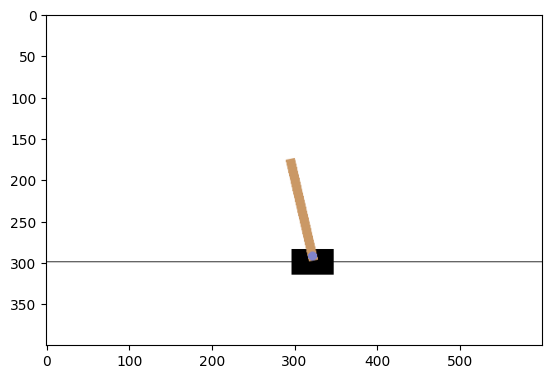

In [ ]:
# Assuming `agent` is an instance of your agent class
test_agent(agent)

In [ ]:
# create env
env = gym.make("MountainCar-v0")
# draw samples from env to fit scaler and rbf kernels
X = np.array([env.observation_space.sample() for _ in range(10000)])
# create standard scaler
scaler = StandardScaler()
# fit scaler to samples
X = scaler.fit_transform(X)
# create rbf sampler object
rbf_samplers = []
for e,s in enumerate([5.0, 2.0, 1.0, 0.5]):
    rbf_samplers.append((f'rbf{e}',RBFSampler(gamma=s, n_components=500, random_state=42)))
# create a FeatureUnion object of RBFSamplers
rbf_union = FeatureUnion([*rbf_samplers])
rbf_union.fit(X)
models = [SGDRegressor(max_iter=100, random_state=42, eta0=0.01) for _ in range(3)]
#perform initial fit with dummy variables to initialize models
for model in models:
    model.partial_fit(rbf_union.transform([env.reset()[0]]), [0])
agent = RBF_Mountain_car_Agent()

In [ ]:
# set parameters of agent
agent.env = env
agent.scaler = scaler
agent.rbf_union = rbf_union
agent.models = models
agent.learning_rate = 0.01
agent.gamma = 0.99
agent.epsilon = 0
agent.RBFSamplers = rbf_samplers
agent.n_steps = 5

In [ ]:
# reset the env
state, _ = agent.env.reset()
# instantiate a list used to track state,action,reward pairs used in an update
sar_tracker = []
# enter a loop that will take a step in the env, record (state, action, reward),
# and update the model until termination of episode
done = False
tot_reward = 0
while not done:
    # get action
    action = agent.get_action([state])
    # take step using action
    next_state, reward, term, trunc, _ = agent.env.step(action)
    # update total reward collected during episode
    tot_reward += reward
    # append state, action, reward to sar_tracker array
    sar_tracker.append((state, action, reward))
    # if the lenght of the sar_tracker array is equal to the n_step parameter value,
    # then update the model using the sar_tracker array
    if len(sar_tracker) == agent.n_steps:
        update(sar_tracker, next_state)
        # remove first state from tracker as Q for that state has been updated
        sar_tracker.remove(sar_tracker[0])
    # update state
    state = next_state
    if term or trunc:
        done = True


update fired...
target_a: 0.0
target_b: 0.0
target_c: -5.0
update fired...
target_a: 0.0
target_b: 0.0
target_c: -5.0
update fired...
target_a: 0.0
target_b: 0.0
target_c: -5.0
update fired...
target_a: -0.21687610595489842
target_b: -0.20624701882416652
target_c: -5.2062470188241665
update fired...
target_a: -0.21719388959723435
target_b: -0.20654922790604896
target_c: -5.206549227906049
update fired...
target_a: -0.21728223218285744
target_b: -0.20663324082595896
target_c: -5.206633240825959
update fired...
target_a: -0.41145569422247413
target_b: -0.39129027118026977
target_c: -5.39129027118027
update fired...
target_a: -0.4091290376431719
target_b: -0.38907764392381894
target_c: -5.389077643923819
update fired...
target_a: -0.411915558270428
target_b: -0.3917275973141806
target_c: -5.391727597314181
update fired...
target_a: -0.5885345645282384
target_b: -0.5596905148885841
target_c: -5.559690514888584
update fired...
target_a: -0.5847692489915935
target_b: -0.556109737278501
targe

In [ ]:
len(sar_tracker)

4

In [ ]:
def update(sar_tracker, next_state):
    """
    updates the model weights using the sar_tracker array.
    Parameters:
    -sar_tracker: tracks the (state, action, reward) combinations used in an update.

    Returns:
    -None
    """
    print('update fired...')
    # get action taken at next state
    action = agent.get_action([next_state])
    # predict return taking action at the next state
    # target = agent.models[action].predict([next_state])
    target = agent.predict([next_state])[action]
    print(f'target_a: {target}')
    # multiply target by discount factor (gamma) which is gamma^n_steps
    target = target*agent.gamma**len(sar_tracker)
    print(f'target_b: {target}')
    # add discounted return to the sum of rewards from previous states in tracker
    target += np.sum([r for s,a,r in sar_tracker])
    print(f'target_c: {target}')
    # grab first state from sar_tracker to be used as 'x' value in partial fit
    # function of model
    s,a,r = sar_tracker[0]
    s = agent.scaler.transform([s])
    s = agent.rbf_union.transform(s)
    agent.models[action].partial_fit(s, [target])

In [ ]:
# calculate return at initial state
s,a,r = sar_tracker[0]
print(f's: {s}, a: {a}, r: {r}')
s = scaler.transform([s])
s = rbf_union.transform(s)
prediction = models[a].predict(s)
print(prediction)

s: [1.1, 0.4], a: 1, r: -2
[0.]


In [ ]:
# calculate return at final state in sar_tracker and then add total reward from states 2-end [1:]

s,a,r = sar_tracker[-1]
print(f's: {s}, a: {a}, r: {r}')
s = scaler.transform([s])
s = rbf_union.transform(s)
target = models[a].predict(s)
print(target)
target += np.sum([r for s,a,r in sar_tracker[1:]])
print(f'target: {target}')

s: [0.4, 0.6], a: 2, r: -1
[0.]
target: [-2.]


In [ ]:
sar_tracker.remove(sar_tracker[0])


In [ ]:
state, _ = env.reset()
for i in range(10):



[([1.4, 0.2], 0, -1), ([0.4, 0.6], 2, -1)]

In [ ]:
# each reward, except the first reward received, needs to be discounted by a factor of gamma

rewards = np.array([-1.0,-1.0,-1.0,-1.0])
gamma = 0.9
for i in range(len(rewards)):
    rewards[i] = rewards[i] * gamma**i
sum(rewards)


-3.439

In [ ]:
gamma**0

1.0

In [ ]:
sar_tracker = [([1.1, 0.9], 0, -1), ([1.4, 0.4], 1, -1), ([0.3, 2.0], 2, -1), ([1.2, 0.3], 0, -1)]

np.sum([r*gamma**i for i,(s,a,r) in enumerate(sar_tracker)])

-3.439

In [ ]:
np.array([env.observation_space.sample() for _ in range(10000)]).shape

(10000, 4)

In [ ]:
# play a bunch of episodes and collect all the states to sample from them for
# rbf kernels and scale to it

# run a bunch of episodes and collect each state visited
states = []

for i in range(10000):
    done = False
    state, _ = env.reset()
    states.append(state)
    while not done:
        action = env.action_space.sample()
        next_state, reward, term, trunc, _ = env.step(action)
        states.append(next_state)
        if term or trunc:
            done = True



In [ ]:
states

[array([-0.04114367, -0.0146307 ,  0.04465247,  0.00080533], dtype=float32),
 array([-0.04143628, -0.21036364,  0.04466857,  0.30723557], dtype=float32),
 array([-0.04564356, -0.01590572,  0.05081329,  0.02896781], dtype=float32),
 array([-0.04596167,  0.1784521 ,  0.05139264, -0.24725994], dtype=float32),
 array([-0.04239263, -0.01736472,  0.04644744,  0.06118027], dtype=float32),
 array([-0.04273992,  0.17706156,  0.04767105, -0.216494  ], dtype=float32),
 array([-0.03919869,  0.37147075,  0.04334117, -0.49376652], dtype=float32),
 array([-0.03176928,  0.1757652 ,  0.03346584, -0.18774553], dtype=float32),
 array([-0.02825397,  0.37039277,  0.02971093, -0.4696863 ], dtype=float32),
 array([-0.02084612,  0.56508267,  0.0203172 , -0.7528586 ], dtype=float32),
 array([-0.00954446,  0.36968657,  0.00526003, -0.45385203], dtype=float32),
 array([-0.00215073,  0.56473374, -0.00381701, -0.74487233], dtype=float32),
 array([ 0.00914394,  0.7599082 , -0.01871446, -1.038754  ], dtype=float32),

In [ ]:
# create a scaler object and fit and transform states
scaler = StandardScaler()
states = scaler.fit_transform(states)

In [ ]:
states

array([[-0.4426546 , -0.04367049,  0.44278388,  0.0081417 ],
       [-0.44561413, -0.39784059,  0.44294407,  0.37464018],
       [-0.48816692, -0.04597757,  0.50406589,  0.04182475],
       ...,
       [-0.4907462 , -1.10414641,  1.75339135,  1.4431109 ],
       [-0.61225813, -1.46044489,  1.99223724,  1.85260144],
       [-0.77360121, -1.81670249,  2.2991959 ,  2.2687569 ]])

In [ ]:
# create RBF kernels and an RBF union and fit the kernels to the data
rbf_samplers = create_rbf_samplers([0.05, 0.1, 0.5, 1.0], [1000, 1000, 1000, 1000])
# create a FeatureUnion object of RBFSamplers
rbf_union = FeatureUnion([*rbf_samplers])
rbf_union.fit(states)

FeatureUnion(transformer_list=[('rbf0',
                                RBFSampler(gamma=0.05, n_components=1000)),
                               ('rbf1',
                                RBFSampler(gamma=0.1, n_components=1000)),
                               ('rbf2',
                                RBFSampler(gamma=0.5, n_components=1000)),
                               ('rbf3', RBFSampler(n_components=1000))])

In [ ]:
# re-code a new agent class that uses scikit learn library
class Agent:
    def __init__(self):
        self.env = None
        self.scaler = None
        self.rbf_union = None
        self.model = None
        self.learning_rate = None
        self.gamma = None
        self.epsilon = None
        self.epsilon_decay = None
        self.min_epsilon = None
        self.RBFSamplers = None
        self.n_steps = None


    def get_action(self, state):
        """
        Get action from the Q-table.

        Parameters:
        -state: int of length n_features representing the assigned bin of each feature

        Returns:
        -action: random or optimal action
        """
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(state))

    def run_episode(self):
        """
        Run an episode of the agent.

        Returns:
        -tot_reward: Total reward for the episode.
        """
        state, _ = self.env.reset()
        # print(f'state shape: {state.shape}')
        if len(state.shape) == 1:
            state = state.reshape(1,-1)
            # print(f'state reshaped to: {state.shape}')
        done = False
        tot_reward = 0
        tot_loss = 0
        sar_tracker = []
        while not done:
            action = self.get_action(state)
            # decay epsilon
            next_state, reward, term, trunc, _ = self.env.step(action)
            # print(f'next state shape: {next_state.shape}')
            if len(next_state.shape) == 1:
                next_state = next_state.reshape(1,-1)
                # print(f'reshaped next state shape to: {next_state.shape}')
            sar_tracker.append((state, action, reward))
            tot_reward += reward
            # calculate TD loss and add to tot_loss
            tot_loss += (reward + self.gamma * np.max(self.predict(next_state))) - self.predict(state)[action]
            if len(sar_tracker) == self.n_steps:
                self.update(sar_tracker, next_state)
                # remove first state from tracker as Q for that state has been updated
                sar_tracker.remove(sar_tracker[0])

            state = next_state
            if term or trunc:
                done = True
        return tot_reward, tot_loss






    def train(self, env, model, episodes, learning_rate, gamma, epsilon, epsilon_decay, min_epsilon, n_steps, scaler=None, feature_union=None):
        """
        Train the agent for a number of episodes.

        Parameters:
        -env: the gymnasium environment the agent will learn on
        -episodes: Number of episodes to train for.
        -learning_rate: learning rate of the regression model
        -gamma: Discount factor of future rewards.
        -epsilon: Epsilon greedy random action threshold.
        -epsilon_decay: factor epsilon is multiplied by after every completed episode
        -min_epsilon: the minimum number epsilon can be
        -n_steps: number of steps taken before updating Q value of a (state, action) pair
        -scaler: a StandardScaler() object used to scale state value
        -feature_union: a FeatureUnion() object used to project state space onto a higher dimensional feature space


        Returns:
        -rewards: List of rewards per episode.
        -losses: List of losses per episode.
        """

        self.env = env
        self.model = model
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.n_steps = n_steps
        self.scaler = scaler
        self.feature_union = feature_union

        rewards = []
        losses = []
        for i in range(episodes):
            reward, loss = self.run_episode()
            rewards.append(reward)
            losses.append(loss)
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            if i % 1 == 0:
                print(f"Episode {i}; episode reward: {rewards[-1]}; AVG/10 reward: {np.mean(rewards[-10:])}; AVG/10 loss: {np.mean(losses[-10:])}")

        return rewards, losses

    def predict(self, state):
        """
        returns predictions.
        Parameters:
        -state: state to run prediction on.

        Returns:
        -predictions:
        """
        if self.scaler:
            state = self.scaler.transform(state)
        if self.RBFSamplers:
            state = self.rbf_union.transform(state)
        predictions = np.array([m.predict(state)[0] for m in self.models])
        return predictions

    def update(self, sar_tracker, next_state):
        """
        updates the model weights using the sar_tracker array.
        Parameters:
        -sar_tracker: tracks the (state, action, reward) combinations used in an update.

        Returns:
        -None
        """
        # get action taken at next state
        action = self.get_action(next_state)
        # predict return taking action at the next state
        # target = agent.models[action].predict([next_state])
        target = self.predict(next_state)[action]
        # multiply target by discount factor (gamma) which is gamma^n_steps
        target = target*self.gamma**len(sar_tracker)
        # add discounted return to the sum of rewards from previous states in tracker
        target += np.sum([r*self.gamma**i for i,(s,a,r) in enumerate(sar_tracker)])
        # grab first state from sar_tracker to be used as 'x' value in partial fit
        # function of model
        s,a,r = sar_tracker[0]
        if self.scaler:
            s = self.scaler.transform([s])
        if self.RBFSamplers:
            s = self.rbf_union.transform(s)
        self.models[action].partial_fit(s, [target])

In [ ]:
models = [SGDRegressor(max_iter=episodes, eta0=self.learning_rate) for _ in range(self.env.action_space.n)]
        # run partial fit on each to initialize model weights to make initial target and prediction values
        for m in self.models:
            m.partial_fit(self.rbf_union.transform([self.env.reset()[0]]), [0])

# From Scratch

In [ ]:
import gymnasium as gym
import numpy as np
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import FeatureUnion
from typing import List, Union

In [ ]:
# instantiate scaler
scaler = StandardScaler()

In [ ]:
def create_rbf_samplers(sigmas, n_components):
    rbf_samplers = []
    for e,(s,n) in enumerate(zip(sigmas, n_components)):
        rbf_samplers.append((f'rbf{e}',RBFSampler(gamma=s, n_components=n)))
    return rbf_samplers

In [ ]:
# instantiate rbf kernels and merge into a feature union
rbf_samplers = create_rbf_samplers([0.05, 0.1, 0.5, 1.0], [1000, 1000, 1000, 1000])
# create a FeatureUnion object of RBFSamplers
rbf_union = FeatureUnion([*rbf_samplers])

In [ ]:
# instantiate cartpole env
env = gym.make('CartPole-v1')

In [ ]:
# collect sample states to fit scaler and rbf kernels
sample_states = get_sample_states(env, 10000)

In [ ]:
# scale the sample states
sample_states = scaler.fit_transform(sample_states)

In [ ]:
# fit the scaled sample states to the rbf kernel feature union
rbf_union.fit(sample_states)

FeatureUnion(transformer_list=[('rbf0',
                                RBFSampler(gamma=0.05, n_components=1000)),
                               ('rbf1',
                                RBFSampler(gamma=0.1, n_components=1000)),
                               ('rbf2',
                                RBFSampler(gamma=0.5, n_components=1000)),
                               ('rbf3', RBFSampler(n_components=1000))])

In [ ]:
# code a regressor model
class SGDRegressor():

    def __init__(self, X, learning_rate):
        self.w = np.random.randn(X.shape[1]) / np.sqrt(X.shape[1])
        self.learning_rate = learning_rate


    def partial_fit(self, X, y):
        """
        updates model weights
        -X: state.
        -y: target value.
        """
        # get pred
        pred = self.predict(X)
        # update model
        # self.w-=self.learning_rate*(X.T.dot(pred-y))
        self.w-=self.learning_rate*(pred-y).dot(X)


    def predict(self, X):
        """
        run forward pass on X.
        Parameters:
        -X: state.
        """
        # run forward pass
        return X.dot(self.w)


In [ ]:
# run sample_states through srbf_kernel to feed to SGDRegressor constructor for weight shaping
scaled_samples = rbf_union.transform(sample_states)

In [ ]:
# create models
models = [SGDRegressor(scaled_samples, 0.1) for m in range(env.action_space.n)]
# code a RL loop
num_episodes = 2000
epsilon = 1.0
gamma = 0.97
# set a random state to reproduce results
np.random.seed(42)


# initialize model
rewards = []

for n in range(num_episodes):
    # reset env
    state, _ = env.reset()
    # check if state is 1D and if so, make 2D
    state = np.atleast_2d(state)
    # transform state
    state = scaler.transform(state)
    state = rbf_union.transform(state)
    episode_reward = 0
    done = False
    # set epsilon value for episode
    eps = epsilon/np.sqrt(n+1)
    while not done:

        # choose action
        if np.random.random() < eps:
            action = env.action_space.sample()
        else:
            action = np.argmax([m.predict(state) for m in models])
        # take action
        next_state, reward, term, trunc, _ = env.step(action)
        # update reward
        episode_reward += reward
        # transform next state
        next_state = np.atleast_2d(next_state)
        next_state = scaler.transform(next_state)
        next_state = rbf_union.transform(next_state)
        # update while loop
        if term or trunc:
            done = True
            if term:
                reward = -200
        # update model
        G = reward + gamma*models[action].predict(next_state)
        models[action].partial_fit(state, G)
        # update state
        state = next_state
    rewards.append(episode_reward)
    if n % 100 == 0:
        print(f'episode {n}: reward={episode_reward} AVG/100={np.mean(rewards[-100:])} epsilon={eps}')


episode 0: reward=16.0 AVG/100=16.0 epsilon=1.0
episode 100: reward=500.0 AVG/100=243.23 epsilon=0.09950371902099892


KeyboardInterrupt: ignored

In [33]:
class Layer:
    def __init__(self, output_dim: int, input_dim: int=None):
        self.input_dim = input_dim
        self.output_dim = output_dim
        # Initialize the weights, for example using random values
        # self.w = np.random.randn(input_dim, output_dim)

    def _init_weights(self):
        # Initialize the weights
        self.w = np.random.randn(self.input_dim, self.output_dim)

    def forward(self, x):
        # Forward pass
        pass

    def backward(self, grad, learning_rate):
        # Backward pass
        pass

class DenseLayer(Layer):
    def __init__(self, output_dim: int, input_dim: int=None):
        super().__init__(output_dim, input_dim)

    def forward(self, x):
        # Forward pass
        self.x = x
        return self.x.dot(self.w)

    def backward(self, grad, learning_rate, action):
        # Backward pass & update weights
        # self.w-=self.learning_rate*(X.T.dot(pred-y))
        self.w[:,action] -= learning_rate*grad.dot(self.x)

class Loss:
    def __init__(self):
        pass

    def forward(self, pred, y):
        # Forward pass
        pass

    def backward(self, pred, y):
        # Backward pass
        pass

class MeanSquaredError(Loss):
    def __init__(self):
        pass

    def forward(self, pred, y):
        # Forward pass
        return np.mean((pred-y)**2)

    def backward(self, pred, y):
        # Backward pass
        return pred-y
    
class TDError(Loss):
    def __init__(self, lmbda: float=0.0):
        self.e = 0 #eligibility trace
        self.lmbda = lmbda
    
    def forward(self, pred, y):
        # Forward pass
        return np.mean((pred-y)**2)

    def backward(self, pred, y):
        # Backward pass
        self.e = (pred-y) + (self.lmbda*self.e)
        return self.e

# Model class
class Model:
    def __init__(self, layers: List[Layer], loss: Loss, input_data: np.ndarray, learning_rate: float=0.1, learning_rate_decay: Union[bool, str]=False, decay_rate: float=0.97, min_learning_rate: float=0.001):
        self.layers = layers
        self.loss = loss
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.decay_rate = decay_rate
        self.min_learning_rate = min_learning_rate
        self._compile(input_data)

    def _compile(self, input_data):
        input_dim = input_data.shape[1]
        for layer in self.layers:
            layer.input_dim = input_dim
            layer._init_weights()
            input_dim = layer.output_dim


    def get_learning_rate(self, episode: int):
        if self.learning_rate_decay == 'constant':
            return self.learning_rate
        elif self.learning_rate_decay == 'exponential':
            return max(self.min_learning_rate, self.learning_rate * np.exp(-self.decay_rate*episode))
        elif self.learning_rate_decay == 'linear':
            return max(self.min_learning_rate, self.learning_rate - self.decay_rate * episode)
        elif self.learning_rate_decay == 'inverse':
            return max(self.min_learning_rate, self.learning_rate / (1 + self.decay_rate * episode))
        else:
            return self.learning_rate



    def predict(self, x):
        # Forward pass
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def update(self, x, y, action, episode):
        # Backward pass
        grad = self.loss.backward(self.predict(x)[:,action], y)
        for layer in reversed(self.layers):
            grad = layer.backward(grad, self.get_learning_rate(episode), action)

# Agent class
class Agent:
    def __init__(self, env, model: Model, transformer=None, epsilon=0.1, min_epsilon=0.1, epsilon_decay=0.99, gamma=0.9, step_reward=None, term_reward=None):
        self.env = env
        self.model = model
        self.transformer = transformer
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.step_reward = step_reward
        self.term_reward = term_reward

    def get_epsilon(self, episode):
        return max(self.min_epsilon, self.epsilon*np.exp(-self.epsilon_decay*episode))

    def get_action(self, state, episode):
        if np.random.random() < self.get_epsilon(episode):
            return self.env.action_space.sample()
        else:
            return np.argmax(self.model.predict(state))

    def play(self, n_episodes: int, render: bool=False)-> list[int]:
        rewards = []
        for episode in range(n_episodes):
            # re-instantiate environment with render mode set to 'human'
            self.env = gym.make(self.env.spec.id, render_mode="human")
            # Reset the environment
            state, _ = self.env.reset()
            # make sure state is 2d arrray
            state = np.atleast_2d(state)
            if self.transformer:
                    state = self.transformer.transform(state)
            done = False
            total_reward = 0
            while not done:
                # set the environment to render in real time
                if render:
                    self.env.render()
                action = np.argmax(self.model.predict(state))
                next_state, reward, term, trunc, _ = self.env.step(action)
                # make sure next state is a 2D array
                next_state = np.atleast_2d(next_state)
                # transform next state if exists
                if self.transformer:
                    next_state = self.transformer.transform(next_state)
                if term or trunc:
                    done = True
                total_reward += reward
                # update state
                state = next_state
            # close the renderer if done
            if render:
                self.env.close()
            rewards.append(total_reward)
        return rewards


    def train(self, n_episodes, streamlit=False, update_freq=1):
        rewards = []
        for episode in range(n_episodes):
            # Reset the environment
            state, _ = self.env.reset()
            # make sure state is 2d arrray
            state = np.atleast_2d(state)
            if self.transformer:
                    state = self.transformer.transform(state)
            done = False
            total_reward = 0
            while not done:
                action = self.get_action(state, episode)
                next_state, reward, term, trunc, _ = self.env.step(action)
                if self.step_reward:
                    reward += self.step_reward
                total_reward += reward
                # make sure next state is a 2D array
                next_state = np.atleast_2d(next_state)
                # transform next state if exists
                if self.transformer:
                    next_state = self.transformer.transform(next_state)
                if term or trunc:
                    done = True
                    if term and self.term_reward:
                        reward += self.term_reward
                # update model
                G = reward + self.gamma*np.max(self.model.predict(next_state))
                self.model.update(state, G, action, episode)
                # update state
                state = next_state
            rewards.append(total_reward)
            if streamlit:
                if episode % update_freq == 0:
                    # print({
                    #     'episode': episode,
                    #     'total_reward': total_reward,
                    #     'avg_reward': np.mean(rewards[-100:]),
                    #     'epsilon': self.get_epsilon(episode),
                    #     'learning_rate': self.model.get_learning_rate(episode)
                    # })  # Print values for debugging
                    yield {
                        'episode': episode,
                        'total_reward': total_reward,
                        'avg_reward': np.mean(rewards[-100:]),
                        'epsilon': self.get_epsilon(episode),
                        'learning_rate': self.model.get_learning_rate(episode)
                    }
            elif episode % 100 == 0:
                print(f'episode {episode}: reward={total_reward} AVG/100={np.mean(rewards[-100:])} epsilon={self.get_epsilon(episode)}')

class Transformer:
    def __init__(self):
        self.transformers = []

    def add(self, transformer):
        self.transformers.append(transformer)

    def transform(self, x):
        for transformer in self.transformers:
            x = transformer.transform(x)
        return x

    def fit(self, x):
        for transformer in self.transformers:
            x = transformer.fit_transform(x)
        # return x

# write a function to gather sample states from env by taking random actions over episodes
def get_sample_states(env, n_episodes):
    """
    Plays n_episode number of episodes using random actions and returns states.
    Parameters:
    -env: gym environment.
    -n_episodes: number of episodes to play.

    Returns:
    -states: list of states.
    """

    states = []

    for i in range(n_episodes):
        done = False
        state, _ = env.reset()
        states.append(state)
        while not done:
            action = env.action_space.sample()
            next_state, reward, term, trunc, _ = env.step(action)
            states.append(next_state)
            if term or trunc:
                done = True
    return np.array(states)

def create_rbf_samplers(sigmas, n_components):
    rbf_samplers = []
    for e,(s,n) in enumerate(zip(sigmas, n_components)):
        rbf_samplers.append((f'rbf{e}',RBFSampler(gamma=s, n_components=n)))
    return rbf_samplers

In [34]:
env = gym.make("MountainCar-v0")
sample_states = get_sample_states(env, 1000)
transformer = Transformer()
scaler = StandardScaler()
transformer.add(scaler)
rbf_samplers = create_rbf_samplers([0.01, 0.05, 0.1, 0.5, 1.0, 2.0],[500, 500, 500, 500, 500, 500])
rbf_union = FeatureUnion([*rbf_samplers])
transformer.add(rbf_union)
transformer.fit(sample_states)
sample_states = transformer.transform(sample_states)

In [35]:
layers = [
    DenseLayer(3),
]

In [36]:
loss = TDError()

In [37]:
model = Model(
    layers = layers,
    loss = loss,
    input_data = sample_states,
    learning_rate = 0.1,
    learning_rate_decay = 'inverse',
    decay_rate = 0.01,
    min_learning_rate = 0.001,
)

In [38]:
agent = Agent(
    env,
    model,
    transformer,
    epsilon = 1.0,
    min_epsilon = 0.01,
    gamma = 0.9,
    step_reward = None,
    term_reward = 100,
)

In [42]:
agent.train(1000)

<generator object Agent.train at 0x00000213245E09A0>

In [41]:
agent.epsilon_decay

0.99